In this notebook we show how diffusion models can interpolate between Gaussian processes.

In [9]:
from functools import partial
import jax
import jax.numpy as jnp
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as np

from check_shapes import check_shapes

import neural_diffusion_processes as ndp

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
JITTER = 1e-12

In [3]:
beta_schedule = ndp.sde.LinearBetaSchedule()
x = jnp.linspace(-1, 1, 103)[:, None]
k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=0.25)
k1 = ndp.kernels.WhiteKernel()
# k1 = SquaredExpontialKernel(lengthscale=1.0)
mean_function = lambda x: jnp.zeros_like(x)  # A zero mean function

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def drift(t, yt, x):
    return  - 0.5 * beta_schedule(t) * (yt - mean_function(x)) # [N, 1]
    
@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, N]",)
def diffusion(t, yt, x):
    del yt
    sqrt_K = jnp.linalg.cholesky(k1(x) + JITTER * jnp.eye(len(x)))
    return jnp.sqrt(beta_schedule(t)) * sqrt_K


def solve(key, y0):
    shape = jax.ShapeDtypeStruct(y0.shape, y0.dtype)
    bm = dfx.VirtualBrownianTree(t0=beta_schedule.t0, t1=beta_schedule.t1, tol=1e-3 / 2., shape=shape, key=key)
    terms = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    # logarithmic timesteps to have more steps at small timesteps... 
    ts = t0 + (t1 - t0) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)
    saveat = dfx.SaveAt(ts=ts)
    return dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t0, t1=t1, dt0=1e-3, y0=y0, args=x, saveat=saveat, adjoint=dfx.NoAdjoint())

In [5]:
def sample_gp(key, kernel, mean, x, num_samples: int = 10):
    return ndp.misc.sample_mvn(key, mean(x), kernel(x), num_samples)

In [6]:
seed = 42
key = jax.random.PRNGKey(seed)

# Solves forward SDE for multiple initia states using vmap.
num_samples = 3
key, subkey = jax.random.split(key)
y0s= sample_gp(subkey, k0, mean_function, x, num_samples=num_samples)
subkeys = jax.random.split(key, num=num_samples)
out = jax.vmap(solve, in_axes=[0, 0])(subkeys, y0s)

compiling outer_loop
compiling inner_loop


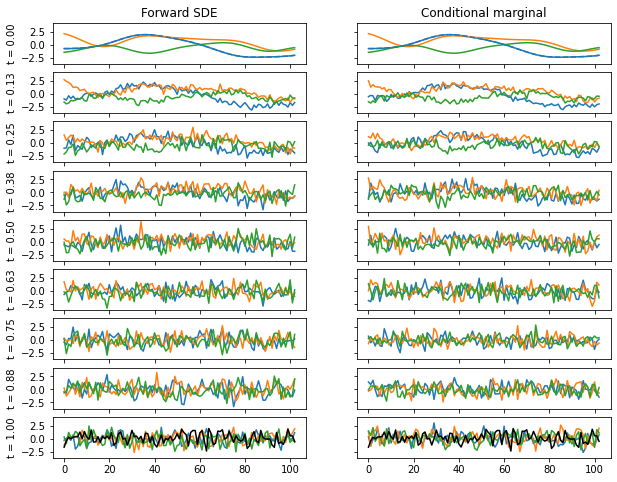

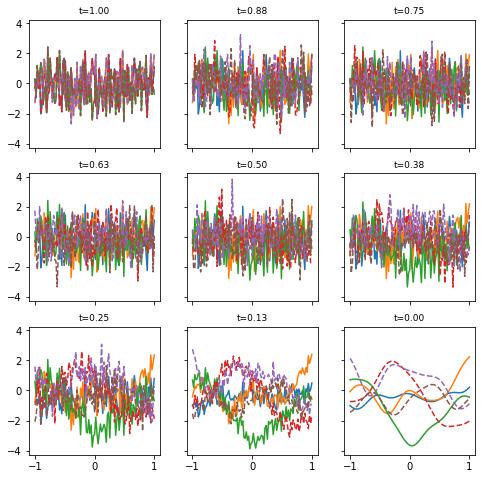

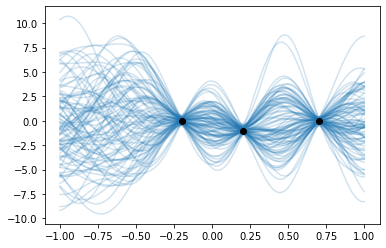

In [10]:
def pt(x, t, y0=None):
    """Marginal of OU process at time t. When passing y0 this returns the conditional marginal."""
    # TODO: change if limiting processes have different mean functions.
    mean0 = mean1 = mean_function
    mean_coef = jnp.exp(-0.5 * beta_schedule.B(t))

    if y0 is None:
        mean = mean_coef * mean0(x) + (1.0 - mean_coef) * mean1(x)
    else:
        mean = mean_coef * y0 + (1.0 - mean_coef) * mean1(x)
    
    if y0 is None:
        cov = k1(x) + jnp.exp(-beta_schedule.B(t)) * (k0(x) - k1(x))
    else:
        cov = (1.0 -  jnp.exp(-beta_schedule.B(t))) * k1(x)
    
    return mean, cov

def sample_pt(key, x, t, y0=None):
    "Marginal distribution p(yt) if y0 is passed p(yt | xt)"
    mean, cov = pt(x, t, y0)
    chol_cov = jnp.linalg.cholesky(cov + JITTER * jnp.eye(len(mean)))
    return mean + (chol_cov @ jax.random.normal(key, (len(mean),1)))



ys = jnp.transpose(out.ys, [1, 0, 2, 3])  # [time, samples, num_points, 1]
ts = jnp.transpose(out.ts, [1, 0])  # [time, samples]

key, subkey = jax.random.split(key)
fig, axes = plt.subplots(len(ts), 2, figsize=(10, 8), sharex=True, sharey=True)
for t_index in range(len(axes)):
    axes[t_index, 0].set_ylabel(f"t = {ts[t_index, 0]:.2f}")
    axes[t_index, 0].plot(ys[t_index, ..., 0].T)

    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, num_samples)
    marginal_samples = jax.vmap(lambda k, y: sample_pt(k, x, ts[t_index, 0], y0=y), in_axes=[0, 0])(subkeys, y0s)
    for j in range(len(marginal_samples)):
        axes[t_index, 1].plot(marginal_samples[j], f"C{j}")

ref_samples = sample_gp(subkey, k1, mean_function, x, num_samples=1)  # [num_samples, num_points, 1]
axes[-1, 1].plot(ref_samples[..., 0].T, "k")
axes[-1, 0].plot(ref_samples[..., 0].T, "k")
axes[0, 0].set_title('Forward SDE')
axes[0, 1].set_title('Conditional marginal')
for j in range(y0s.shape[-1]):
    axes[0, 0].plot(y0s[j, :, 0], f"C{j}--")
    axes[0, 1].plot(y0s[j, :, 0], f"C{j}--")

# plt.show()

# %%
solve_lower_triangular = partial(jax.scipy.linalg.solve_triangular, lower=True)  # L⁻¹ x
solve_upper_triangular = partial(jax.scipy.linalg.solve_triangular, lower=False)  # U⁻¹ x

@check_shapes("yt: [N, 1]", "x: [N, 1]", "t: []", "return: [N, 1]",)
def score(yt, x, t):
    "Exact marginal score in Gaussian setting"
    mu_t, Sigma_t = pt(x, t)
    Lt = jnp.linalg.cholesky(Sigma_t + JITTER * jnp.eye(len(Sigma_t)))
    b = yt - mu_t
    A = solve_upper_triangular(jnp.transpose(Lt), solve_lower_triangular(Lt, b))
    return - k1(x) @ A


@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def reverse_drift_ode(t, yt, x):
    return  drift(t, yt, x) - 0.5 * beta_schedule(t) * score(yt, x, t) # [N, 1]

def reverse_drift_sde(t, yt, x):
    return  drift(t, yt, x) - beta_schedule(t) * score(yt, x, t) # [N, 1]


def reverse_solve(key, yT, prob_flow: bool = True):
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    ts = t1 + (t0 - t1) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)[::-1]
    saveat = dfx.SaveAt(ts=ts)
    # reverse time, solve from t1 to t0
    if prob_flow:
        terms = dfx.ODETerm(reverse_drift_ode)
    else:
        drift = dfx.ODETerm(reverse_drift_sde)
        shape = jax.ShapeDtypeStruct(yT.shape, yT.dtype)
        bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=1e-3 / 2., shape=shape, key=key)
        terms = dfx.MultiTerm(drift, dfx.ControlTerm(diffusion, bm))

    return dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t1, t1=t0, dt0=-1e-3/2., y0=yT, saveat=saveat, args=x, adjoint=dfx.NoAdjoint())


key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, 3)
rev_out = jax.vmap(reverse_solve)(subkeys, ys[-1])

rev_ys = jnp.transpose(rev_out.ys, [1, 0, 2, 3])  # [time, samples, num_points, 1]
rev_ts = jnp.transpose(rev_out.ts, [1, 0])  # [time, samples]

fig, axes = plt.subplots(3,3, figsize=(8, 8), sharex=True, sharey=True)

for i, ax in enumerate(np.array(axes).ravel()):
    # print(rev_ts[i, 0], ts[-i-1, 0])
    ax.set_title(f"t={rev_ts[i,0]:.2f}", fontsize=9)
    ax.plot(x, rev_ys[i, ..., 0].T)
    ax.plot(x, ys[-i-1, ..., 0].T, ls='--')
    # plt.plot(x, sol.ys[i, -1], f"C{i}--")

# %%
def conditional_sample(key, x_context, y_context, x_test, num_steps: int, num_inner_steps: int):
    len_context = len(x_context)
    shape_augmented_state = [len(x_test) + len(x_context), 1]  # assume 1d output

    t0 = beta_schedule.t0
    t1 = beta_schedule.t1
    ts = jnp.linspace(t1, t0, num_steps, endpoint=True)
    dt = ts[0] - ts[1]

    solver = dfx.Euler()
    # reverse ODE:
    ode_terms_reverse = dfx.ODETerm(reverse_drift_ode)

    # reverse SDE:
    # shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    # key, subkey = jax.random.split(key)
    # bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=dt, shape=shape, key=subkey)
    # ode_terms_reverse = dfx.MultiTerm(dfx.ODETerm(reverse_drift_sde), dfx.ControlTerm(diffusion, bm))

    # forward SDE:
    shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    key, subkey = jax.random.split(key)
    bm = dfx.VirtualBrownianTree(t0=t0, t1=t1, tol=dt, shape=shape, key=subkey)
    sde_terms_forward = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))

    def inner_loop(key, yt, t):
        print("compiling inner_loop")
        yt_context = sample_pt(key, x_context, t, y_context)
        yt_augmented = jnp.concatenate([yt_context, yt], axis=0)
        x_augmented = jnp.concatenate([x_context, x_test], axis=0)

        # reverse step
        yt_m_dt, *_ = solver.step(ode_terms_reverse, t, t - dt, yt_augmented, x_augmented, None, made_jump=False)

        # forward step
        yt, *_ = solver.step(sde_terms_forward, t - dt, t, yt_m_dt, x_augmented, None, made_jump=False)

        # strip context from augmented state
        return yt[len_context:], yt_m_dt[len_context:]

    def outer_loop(key, yt, t):
        print("compiling outer_loop")
        _, yt_m_dt = jax.lax.scan(lambda yt, key: inner_loop(key, yt, t), yt, jax.random.split(key, num_inner_steps))
        yt = yt_m_dt[-1]
        return yt, yt


    key, subkey = jax.random.split(key)
    yT = sample_pt(subkey, x_test, 1.0)

    xs = (ts[:-1], jax.random.split(key, len(ts) - 1))
    y0, _ = jax.lax.scan(lambda yt, x: outer_loop(x[1], yt, x[0]), yT, xs)
    return y0


x_known = jnp.reshape(jnp.asarray([[-0.2, 0.2, 0.7]]), (-1, 1))
y_known = jnp.reshape(jnp.asarray([[0.0, -1.0, 0.0]]), (-1, 1))
x_test = jnp.linspace(-1, 1, 101)[:, None]
key = jax.random.PRNGKey(0)
samples = jax.vmap(lambda key: conditional_sample(key, x_known, y_known, x_test, 100, 10))(jax.random.split(key, 100))

# %%
plt.figure()
plt.plot(x_test, samples[..., 0].T, "C0", alpha=.2)
plt.plot(x_known, y_known, "ko")
plt.show()